# Stacked Lorentzians

This comparison is to understand, in a regime like QUENS, whether there is a noteable improvement with multiple simultaneous processes.

## Basic EMTK MLE Method

['/Users/phillipbentley/Code/python/mle', '/Users/phillipbentley/anaconda3/envs/ess/lib/python310.zip', '/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10', '/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/lib-dynload', '', '/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages']
Generated 10000 samples using parameters [0.03 0.6 ]
Double lorentzian curve maximum likelihood estimation
10000 data points
[0.01839816 0.02759724] as initial guess (kappa)
[0.01986767 0.01986767]  +/- [0.00125222 0.00125222]? solution obtained numerically
[0.01986767 0.01986767] solution obtained numerically
That a maximum was found is True via second derivative


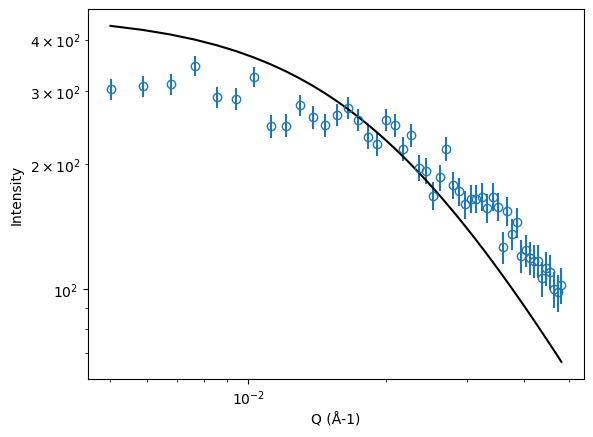

In [7]:
import sys
print(sys.path)

import emtk.quensCurves.lorentzianX2 as lor
import numpy as np
import matplotlib.pyplot as plt

curv = lor.DoubleLorentzian()

hwhm = np.array([0.03, 0.6])
xrange = np.array([0.005, 0.05])

curv.generate_test_samples(hwhm, xrange, 10000)

curv.mle()

curv.report()

curv.plot_fit(logarithmic=True)

Very interesting.  I wasn't expecting that to come up with a double identical solution to the same thing as the average value like in the single lorentzian MLE, I was expecting the parameters to drift apart.

In any case, unfortunately this a fail :S

## Using PyMC

MCMC Bayesian Inference as far as event mode goes requires us to fit the quantile function, not the probability distribution function.  I didn't really think about this point so deeply until now, when I try to use PyMC, but this is basically why this entire activity is so difficult.  We cannot really escape from cumulative distribution functions and their inverses.  Formulating a least squares fit to a histogram is relatively easy to do.

In [15]:
import sys
print(sys.path)

import emtk.curves.lorentzian as lor
import numpy as np
import matplotlib.pyplot as plt

curv = lor.LorentzianCurve()

hwhm = 0.03
xrange = np.array([0.005, 0.05])

npts = 100

curv.generate_test_samples(hwhm, xrange, npts)


['/Users/phillipbentley/Code/python/mle', '/Users/phillipbentley/anaconda3/envs/ess/lib/python310.zip', '/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10', '/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/lib-dynload', '', '/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages']
Generated 100 samples using parameters 0.03


In [18]:
# We now need to create a probabilistic reformulation of a lorentzian.  We are **not** fitting this:
#
#                     g1             
#     I(Q) = ----------------------- 
#            pi * Q^2 + pi * g1^2    
#

# What we are actually fitting is Y = Q, with X in the range 0-1 (p values), and Y as the **quantile** function
# of a lorentzian, in other words
#
# Y ~ alpha + gamma * Tan((X - 0.5)*pi) + sigma
#
# where sigma is random noise, and alpha is the line centre


import pymc as pm
import arviz as az
basic_model = pm.Model()
print(f"PyMC v{pm.__version__}")


xgrid = np.linspace(0, 1, npts)

with basic_model:
    # Lorentzian parameters 
    gamma = pm.HalfNormal("gamma", sigma=0.4)
    alpha = pm.Normal("alpha", mu=0, sigma=0.5)
    # Random noise
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Expected value of outcome
    func = alpha + gamma * np.tan( np.pi * (xgrid-0.5) )
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=func, sigma=sigma, observed=curv.data) 
    
    idata = pm.sample(1000)

PyMC v5.6.1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

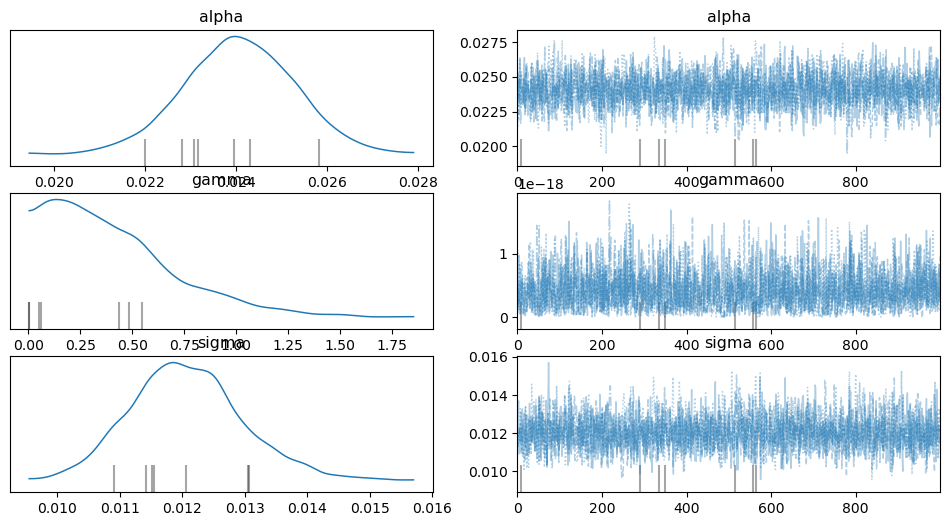

In [19]:
az.plot_trace(idata, combined=True)